imports

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
%pip install seaborn
import seaborn as sns
from pandas.plotting import scatter_matrix
from scipy.stats.mstats import winsorize
from sklearn.model_selection import KFold


read csv files

In [142]:
aisles=pd.read_csv("C:\\Users\\kareem khouri\\Desktop\\project\\datasets\\aisles.csv")
departments=pd.read_csv("C:\\Users\\kareem khouri\\Desktop\\project\\datasets\\departments.csv")
order_products_prior=pd.read_csv("C:\\Users\\kareem khouri\\Desktop\\project\\datasets\\order_products__prior.csv")
order_products_train=pd.read_csv("C:\\Users\\kareem khouri\\Desktop\\project\\datasets\\order_products__train.csv")
orders=pd.read_csv("C:\\Users\\kareem khouri\\Desktop\\project\\datasets\\orders.csv")
products=pd.read_csv("C:\\Users\\kareem khouri\\Desktop\\project\\datasets\\products.csv")

save memory

In [143]:
def reduce_memory(df):
  for column in df.columns:
    if df[column].dtype != object:
      if df[column].dtype == 'int64':
        df[column]=df[column].astype('int32')
      if df[column].dtype == 'float64':
        df[column]=df[column].astype('float32')
  return df
aisles=reduce_memory(aisles) 
departments=reduce_memory(departments) 
order_products_prior=reduce_memory(order_products_prior) 
order_products_train=reduce_memory(order_products_train) 
orders=reduce_memory(orders) 
products=reduce_memory(products)

join files 

In [144]:
all_products=products.merge(aisles,on='aisle_id',how='left')
all_products=all_products.merge(departments,on='department_id',how='left')
df=pd.merge(order_products_prior, all_products, on='product_id', how='left')
df_prior=pd.merge(df, orders, on='order_id', how='left')

In [145]:
df_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


EDA

1-missing value visualization

In [146]:
missing_values=df_prior.isnull().sum()
print(missing_values)

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
dtype: int64


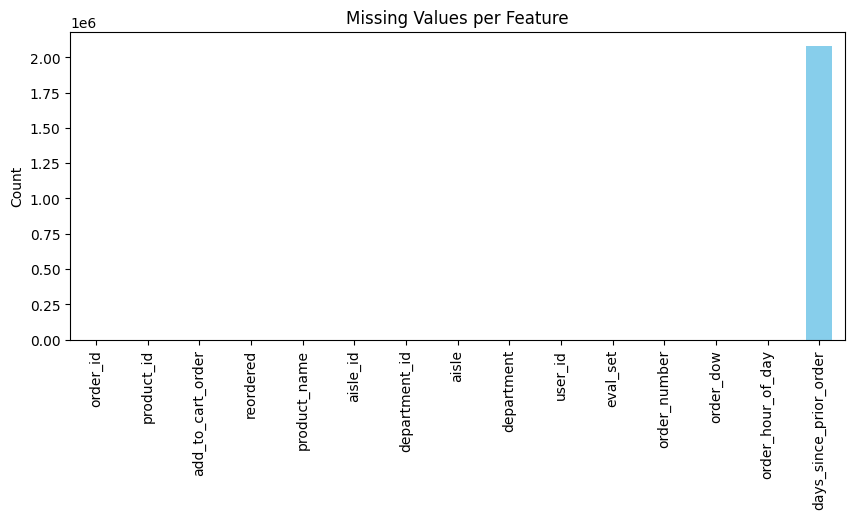

In [147]:
missing_values=df_prior.isnull().sum()
plt.figure(figsize=(10, 4))
missing_values.plot(kind='bar', color='skyblue')
plt.title('Missing Values per Feature')
plt.ylabel('Count')
plt.show()

2-Distribution plots for numeric features and target(s) (histogram, density)

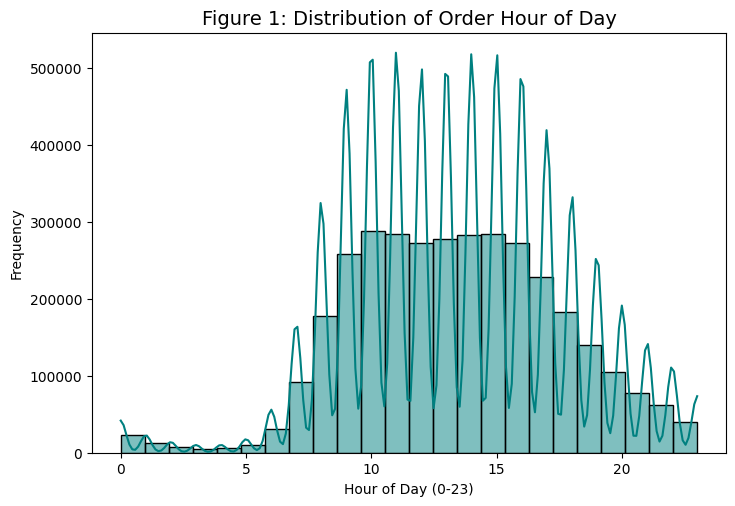

In [148]:
plt.figure(figsize=(18,12))
plt.subplot(2, 2, 1)
sns.histplot(orders['order_hour_of_day'], kde=True, color='teal', bins=24)
plt.title('Figure 1: Distribution of Order Hour of Day', fontsize=14)
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Frequency')
plt.show()

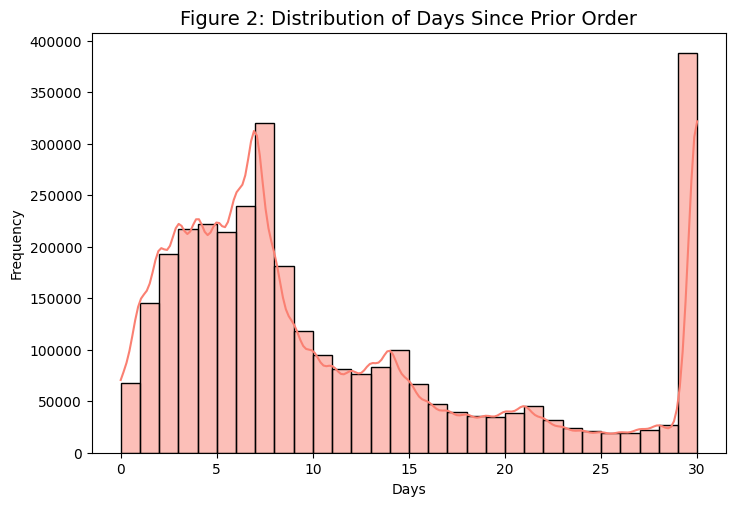

In [149]:
plt.figure(figsize=(18,12))
plt.subplot(2, 2, 2)
sns.histplot(orders['days_since_prior_order'], kde=True, color='salmon', bins=30)
plt.title('Figure 2: Distribution of Days Since Prior Order', fontsize=14)
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.show()

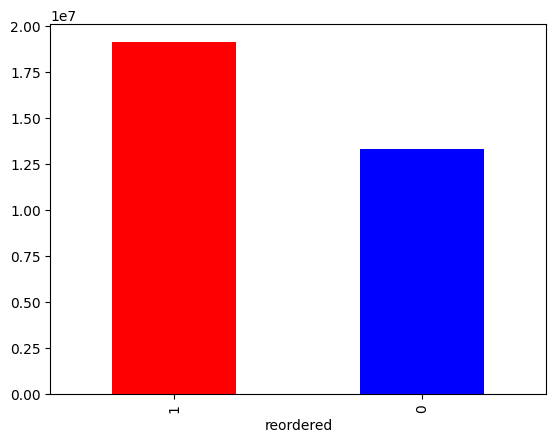

In [150]:
df['reordered'].value_counts().plot(kind='bar', color=['red', 'blue'])
plt.show()

Categorical cardinality analysis

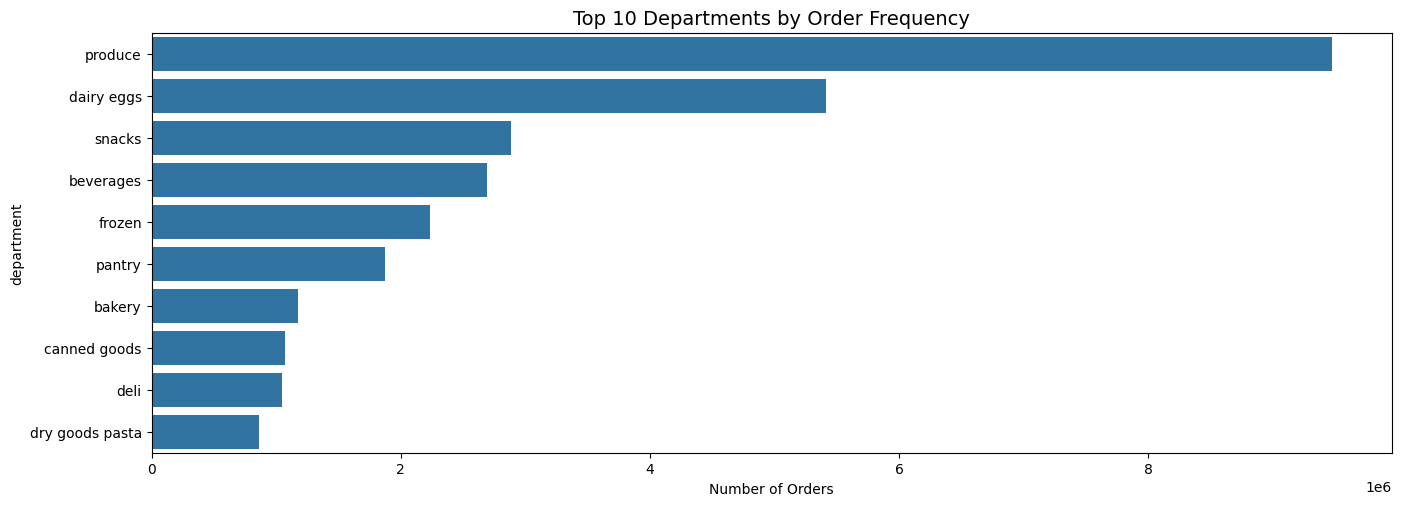

In [151]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 1, 1)
top_departments_counts = df_prior['department'].value_counts().head(10)
sns.barplot(x=top_departments_counts.values, y=top_departments_counts.index)
plt.title('Top 10 Departments by Order Frequency', fontsize=14)
plt.xlabel('Number of Orders')
plt.show()

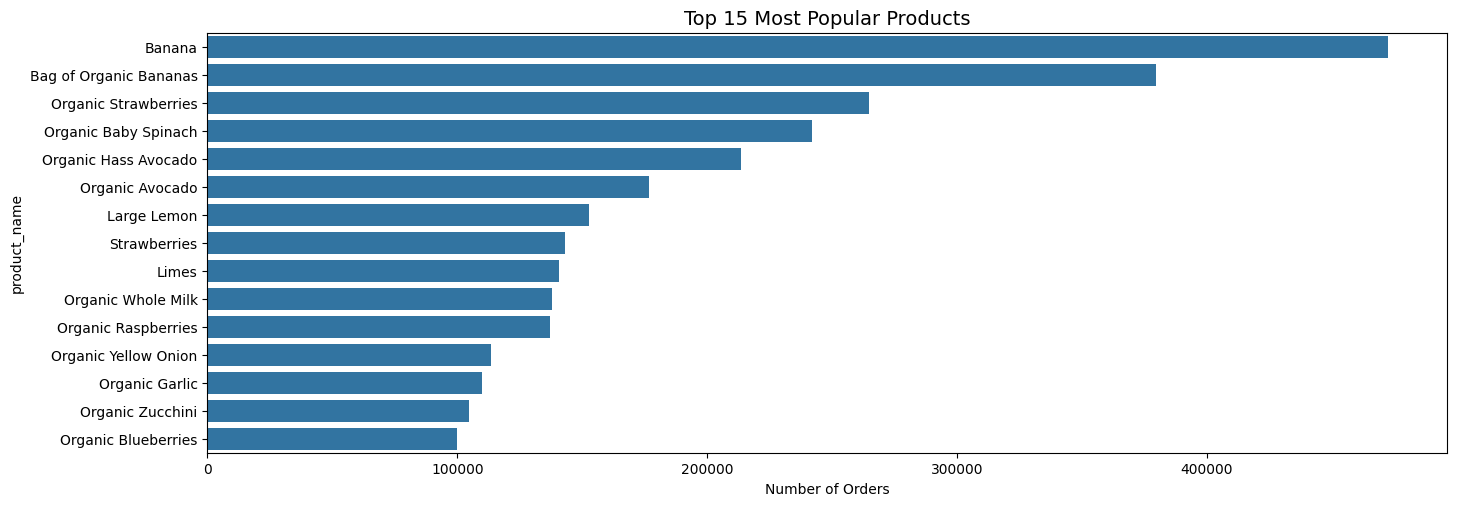

In [152]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 1, 2)
top_products_counts = df_prior['product_name'].value_counts().head(15)
sns.barplot(x=top_products_counts.values, y=top_products_counts.index)
plt.title('Top 15 Most Popular Products', fontsize=14)
plt.xlabel('Number of Orders')
plt.show()

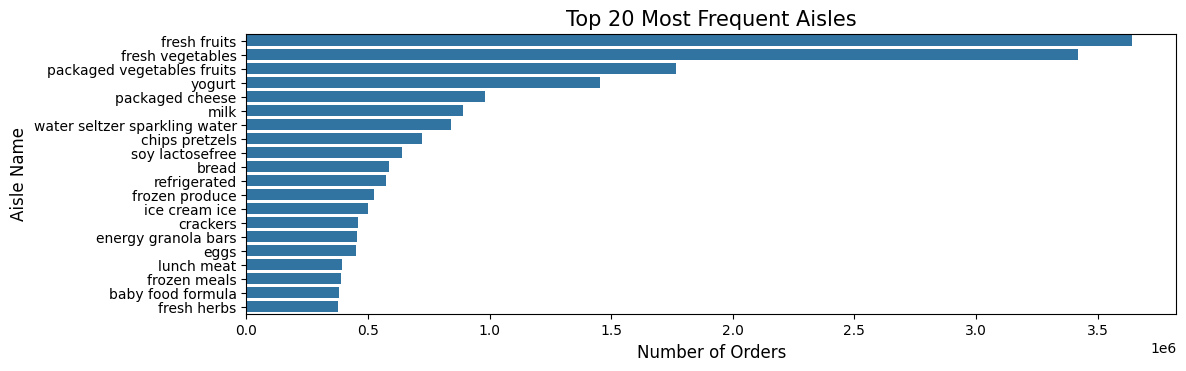

In [153]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 2)
top_aisle_counts = df_prior['aisle'].value_counts().head(20)
sns.barplot(x=top_aisle_counts.values, y=top_aisle_counts.index)
plt.title('Top 20 Most Frequent Aisles', fontsize=15)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Aisle Name', fontsize=12)
plt.show()

Correlation matrix, heatmap and pairwise scatter plots for selected numeric features

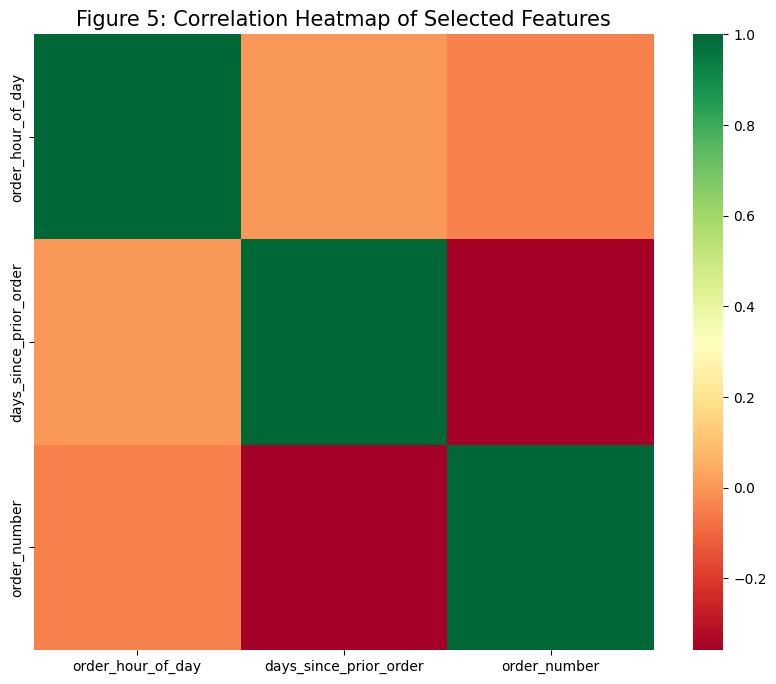

In [154]:
numeric_columns=['order_hour_of_day','days_since_prior_order','order_number']
corr_matrix=df_prior[numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,cmap='RdYlGn')
plt.title('Figure 5: Correlation Heatmap of Selected Features', fontsize=15)
plt.show()


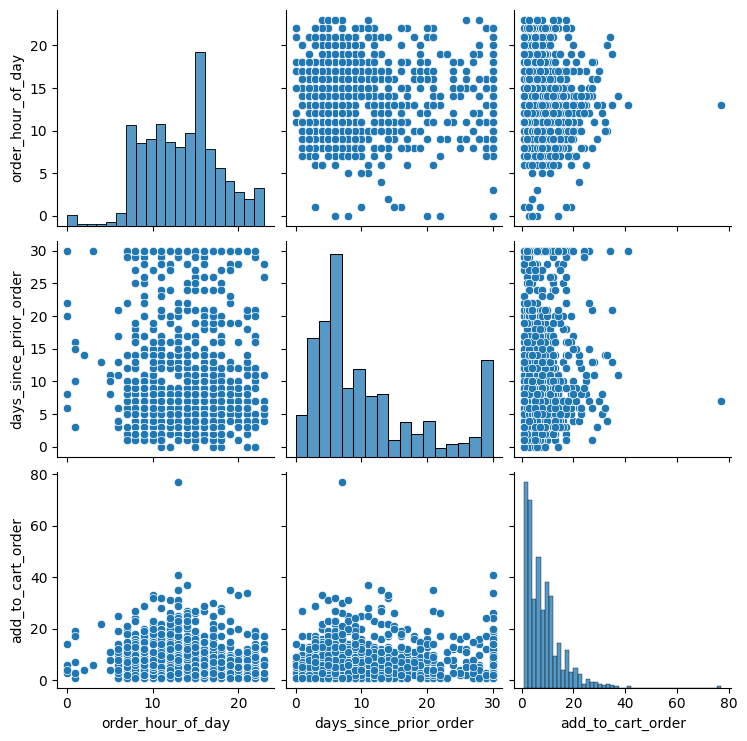

In [155]:
cols = ['order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order']
df_sample = df_prior[cols].sample(1000)
sns.pairplot(df_sample)
plt.show()

Cleaning & Imputation

In [156]:
df_prior['days_since_prior_order_sentinel'] = df_prior['days_since_prior_order'].fillna(-1)
median_value = df_prior['days_since_prior_order'].median()
df_prior['days_since_prior_order'] = df_prior['days_since_prior_order'].fillna(median_value)
print("for insurance:")
print(df_prior['days_since_prior_order'].isna().sum())
print((df_prior['days_since_prior_order_sentinel'] == -1).sum())
print()
print(median_value)
df_prior['days_since_prior_order'].describe()

for insurance:
0
2078068

8.0


count    3.243449e+07
mean     1.090520e+01
std      8.526975e+00
min      0.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      3.000000e+01
Name: days_since_prior_order, dtype: float64

In [157]:
Q1 = df_prior['days_since_prior_order'].quantile(0.25)
Q3 = df_prior['days_since_prior_order'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
outliers = df_prior[(df_prior['days_since_prior_order'] < lower) | (df_prior['days_since_prior_order'] > upper)]
print("Nmber of outliers: ",len(outliers))

Nmber of outliers:  3499046


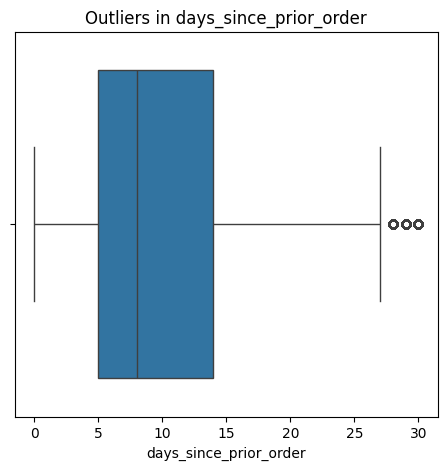

In [158]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(x=df_prior['days_since_prior_order'])
plt.title("Outliers in days_since_prior_order")
plt.show()

In [159]:
df_prior['days_since_prior_order_winsorized'] = winsorize(df_prior['days_since_prior_order'], limits=[0.05, 0.05] )  # winsorization=0.05

In [160]:
upper_limit = df_prior['days_since_prior_order'].quantile(0.95)
(df_prior['days_since_prior_order_winsorized'] > upper_limit).sum()

np.int64(0)

Feature engineering

In [161]:
user_features = df_prior.groupby('user_id').agg(
    total_orders=('order_number', 'max'),
    reorder_ratio=('reordered', 'mean'),
    avg_basket_size=('product_id', 'count') ,
    mean_days_between_orders=('days_since_prior_order','mean'),
    last_order_recency=('days_since_prior_order','last')
).reset_index()
user_features['avg_basket_size'] = user_features['avg_basket_size'] / user_features['total_orders']

product_features=df_prior.groupby('product_id').agg(
    overall_reorder_rate=('reordered', 'mean'),
    average_position_in_cart=('add_to_cart_order','mean'),
    popularity=('order_id', 'count')
).reset_index()


User_Product_interaction=df_prior.groupby(['user_id', 'product_id']).agg(
    prior_purchase_count=('order_id', 'count'),
    days_since_last_purchase=('days_since_prior_order', 'last'),
    avg_reorder_prob=('reordered', 'mean')
).reset_index()

orders['is_weekend'] = orders['order_dow'].apply(lambda x: 1 if x in [0, 1] else 0)
temporal_features = orders[['order_id', 'order_hour_of_day', 'order_dow', 'is_weekend']]
#
last_3_orders = df_prior.sort_values(['user_id', 'order_number']).groupby('user_id').tail(3)
window_features = last_3_orders.groupby('user_id').agg(
    last_3_reorder_rate=('reordered', 'mean')
).reset_index()
#Log Transform (For large numbers) like total_orders
user_features['log_total_orders'] = np.log1p(user_features['total_orders'])
#interaction terms for correlate behavior
user_features['order_delay_ratio'] = user_features['last_order_recency'] / (user_features['mean_days_between_orders'] + 1)







Final Training Set

In [162]:
train_base = order_products_train.merge(orders[['order_id', 'user_id']], on='order_id', how='left')
train_base = train_base[['user_id', 'product_id', 'order_id', 'reordered']] # we removed add to cart order (Data Leakage)(Accuracy increases)


df_final = train_base.merge(user_features, on='user_id', how='left')
df_final = df_final.merge(product_features, on='product_id', how='left')
df_final = df_final.merge(User_Product_interaction, on=['user_id', 'product_id'], how='left')
df_final = df_final.merge(window_features, on='user_id', how='left')
df_final = df_final.merge(temporal_features, on='order_id', how='left')




In [163]:
df_final.head()

,user_id,product_id,order_id,reordered,total_orders,reorder_ratio,avg_basket_size,mean_days_between_orders,last_order_recency,log_total_orders,...,overall_reorder_rate,average_position_in_cart,popularity,prior_purchase_count,days_since_last_purchase,avg_reorder_prob,last_3_reorder_rate,order_hour_of_day,order_dow,is_weekend
0,112108,49302,1,1,3,0.428571,7.0,9.285714,7.0,1.386294,...,0.619632,6.392638,163.0,2.0,7.0,0.5,0.666667,10,4,0
1,112108,11109,1,1,3,0.428571,7.0,9.285714,7.0,1.386294,...,0.713775,7.385957,4472.0,2.0,7.0,0.5,0.666667,10,4,0
2,112108,10246,1,0,3,0.428571,7.0,9.285714,7.0,1.386294,...,0.524553,9.608327,23826.0,NaN,NaN,NaN,0.666667,10,4,0
3,112108,49683,1,0,3,0.428571,7.0,9.285714,7.0,1.386294,...,0.691702,7.662467,97315.0,NaN,NaN,NaN,0.666667,10,4,0
4,112108,43633,1,1,3,0.428571,7.0,9.285714,7.0,1.386294,...,0.477795,9.248086,653.0,2.0,8.0,0.5,0.666667,10,4,0


In [164]:
df_final.isnull().sum()

user_id                          0
product_id                       0
order_id                         0
reordered                        0
total_orders                     0
reorder_ratio                    0
avg_basket_size                  0
mean_days_between_orders         0
last_order_recency               0
log_total_orders                 0
order_delay_ratio                0
overall_reorder_rate             9
average_position_in_cart         9
popularity                       9
prior_purchase_count        555793
days_since_last_purchase    555793
avg_reorder_prob            555793
last_3_reorder_rate              0
order_hour_of_day                0
order_dow                        0
is_weekend                       0
dtype: int64

clean the nan values in df_final

In [ ]:
df_final['overall_reorder_rate'].fillna(0, inplace=True)
df_final['average_position_in_cart'].fillna(df_final['average_position_in_cart'].mean(), inplace=True)
df_final['popularity'].fillna(0, inplace=True)
# we will drop the large number of nan values because if we keep them they the do overfit
columns_to_drop=['prior_purchase_count','days_since_last_purchase','avg_reorder_prob']
df_final=df_final.drop(columns_to_drop,axis=1)

Outlier detection


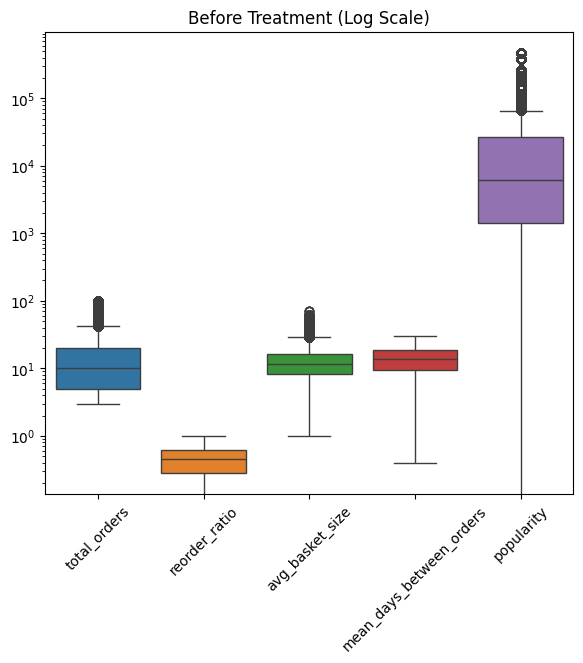

In [184]:


# List of numeric features from your dataset
numeric_cols = [
    'total_orders', 'reorder_ratio', 'avg_basket_size', 
    'mean_days_between_orders','popularity'
]

# Before Treatment
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df_final[numeric_cols])
plt.yscale('log') # Use log scale to handle different feature magnitudes
plt.title("Before Treatment (Log Scale)")
plt.xticks(rotation=45)
plt.show()


In [185]:
#Treatment
for col in numeric_cols:
    if col in df_final.columns:
        df_final[col] = winsorize(df_final[col], limits=[0.01, 0.01])

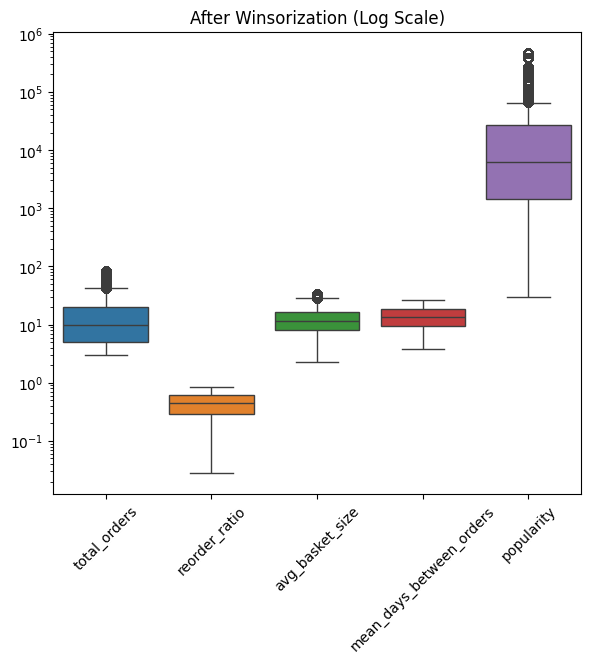

In [186]:
# After Treatment
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 2)
sns.boxplot(data=df_final[numeric_cols])
plt.yscale('log')
plt.title("After Winsorization (Log Scale)")
plt.xticks(rotation=45)
plt.show()

Encoding Categorical Variables